# FarmVibes.AI Green House Gas fluxes

This notebook illustrates how to use the `green_house_gas_fluxes` workflow to
compute Green House Gas emissions and sequestration for a given crop in a given
location and time range.

With this workflow, you can also evaluate potential scenarios and assess
how they would affect your green house gas emission fluxes returned as
[$CO_{2eq}$](https://en.wikipedia.org/wiki/Global_warming_potential).

This workflow follows the
[Greenhouse Gas Protocol Agricultural Guidance](https://ghgprotocol.org/sites/default/files/standards/GHG%20Protocol%20Agricultural%20Guidance%20%28April%2026%29_0.pdf)
and uses the IPCC methodology to compute Scope 1, 2, and 3 emissions of
agricultural land used by farms. The methodology uses emission factors estimated
collected both from IPCC and from the equations devised for Brazil by the GHG
protocol.

In this workflow, users provide the required data for the methodology, submits it,
and gets the reporting data.

In this notebook, after executing the workflow, we will also generate an Excel
spreadsheet ready for importing at a [Microsoft Sustainability
Manager](https://learn.microsoft.com/en-us/industry/sustainability/) instance.

## Agricultural emissions sources

The principal emission sources found on farmland are shown below. They are
divided into *non-mechanical* (either biological processes shaped by climatic
and soil conditions, or the burning of crop residues), and *mechanical*
(equipment and machinery operated on farms).

The main sources and the emitted gases are shown below:

### Mechanical

 * Purchased electricity: $CO_2$, $CH_4$ and $N_2O$.
 * Mobile machinery (tilling, sowing, harvesting, transport and fishing
   vessels): $CO_2$, $CH_4$ and $N_2O$.
 * Stationary machinery (milling and irrigation equipment): $CO_2$, $CH_4$ and
   $N_2O$.
 * Refrigeration and air-condictioning equipment: HFCs and PFCs

### Non-mechanical

 * Drainage and tillage of soils: $CO_2$, $CH_4$ and $N_2O$.
 * Addition of synthetic fertilizers, livestock waste, and crop residues to
   soils: $CO_2$, $CH_4$ and $N_2O$.
 * Addition of urea and lime to soils: $CO_2$
 * Enteric fermentation: $CH_4$
 * Rice cultivation: $CH_4$
 * Manure management: $CH_4$ and $N_2O$
 * Land-use change: $CO_2$, $CH_4$, and $N_2O$
 * Open burning of savannahs and of crop residues left on fields: $CO_2$, $CH_4$, and $N_2O$ 
 * Managed woodland (e.g., tree strips, timberbelts): $CO_2$
 * Composting of organic wastes: $CH_4$
 * Oxidation of horticultural growing media (e.g., peat): $CO_2$

## Returned data

The overall process executed by the workflow called by this Jupyter notebook is the one below:

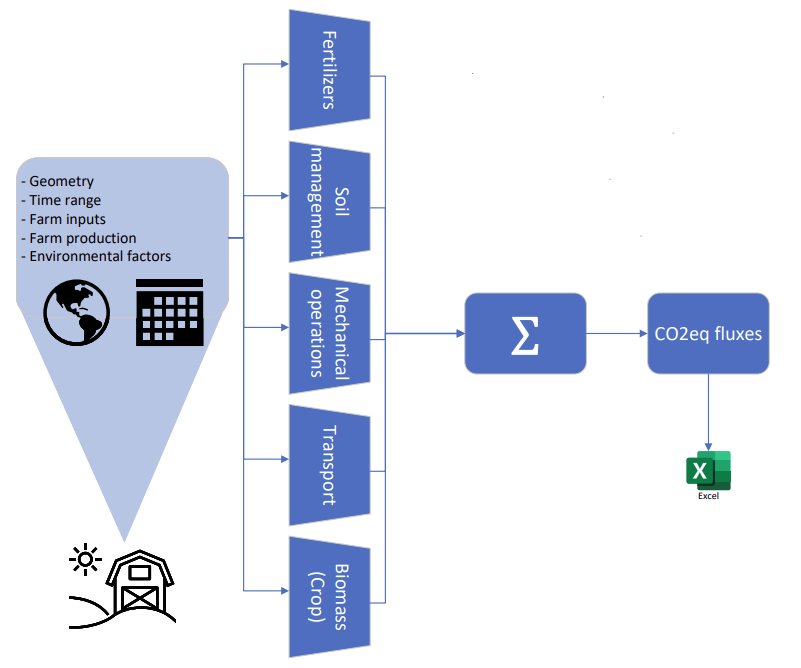

The workflow will return the following total $CO_{2eq}$ emissions:

### Scope 1

 * Urea application
 * Liming
 * Synthetic nitrogen fertilizer
 * Organic amendment
 * Runoff
 * Atmospheric deposition of Nitrogen
 * Residue decomposition
 * Organic Soil Management
 * Mechanical Operations
  * Fossil fuels
  * Biofuels
 * Initial Carbon Stock released when clearing native vegetation (avaiable for
   biomes in Brazil and US Forest)

### Scope 3

 * Transportation

## Supported crops

We currently support computing fluxes for the following crops:

 * Corn
 * Cotton
 * Soybeans
 * Wheat

## Environment setup

To run this notebook, you will need an environment capable of importing the
`vibe_core` library, as well the dependencies for the code. Please refer to
the [notebooks README](../README.md) for instructions on how to set up your
environment.

You will also need the `openpyxl` library to generate the Excel spreadsheet.
You can install it in the following cell.

In [1]:
!pip install --user openpyxl

In [2]:
from datetime import datetime

from shapely import geometry as shpg
from shapely import wkt

from vibe_core.client import get_default_vibe_client
from vibe_core.data.core_types import GHGProtocolVibe

## Farm data for running workflow

Below we will define the various parameters that can be input to the model.

We will begin by defining the time range and geometry of the farm:

In [3]:
time_range = (datetime(2019, 9, 1), datetime(2020, 7, 1))

geometry = wkt.loads(
    "Polygon ((-8.47931009699438576 37.86536075375328636,"
    " -8.19134459346971688 37.86536075375328636,"
    " -8.19134459346971688 38.05647717029316368,"
    " -8.47931009699438576 38.05647717029316368,"
    " -8.47931009699438576 37.86536075375328636))"
)

base = {
    "id": "ficticious_farm_id",
    "time_range": time_range,
    "geometry": shpg.mapping(geometry),
    "biome": "US_FOREST",
}

Next, the data about the soil and practices on the farm:

In [4]:
cultivation = {
    "cultivation_area": 4000,  # in hectares,
    "total_yield": 17040,  # in tons
    "soil_texture_class": "sand",  # sand, clay, silt
    "soil_clay_content": 0.1,  # ratio, 0.0 to 1.0
    "previous_land_use": "conventional_crops",
    "current_land_use": "conventional_crops",
    "practice_adoption_period": 50,  # in years
    "burn_area": 40,  # in hectares
    "soil_management_area": 400,  # in hectares
}

Next, we will define the fertilizer data we used in our farm:

In [5]:
fertilizer = {
    "urea_amount": 5,  # kg/ha
    "synthetic_fertilizer_amount": 10,  # kg/ha
    "synthetic_fertilizer_nitrogen_ratio": 20 / 100.0,  # 0 to 1
    "limestone_calcite_amount": 1,  # kg/ha
    "limestone_dolomite_amount": 2,  # kg/ha
    "gypsum_amount": 3,  # kg/ha
    "organic_compound_amount": 4,  # kg/ha
    "manure_amount": 5,  # kg/ha
    "manure_birds_amount": 0,  # kg/ha
    # Other organic fertilizers:
    "organic_other_amount": 0,  # kg/ha

    "green_manure_amount": 2,  # kg/ha
    "green_manure_grass_amount": 3,  # kg/ha
    "green_manure_legumes_amount": 4,  # kg/ha
}

Next, we define the amount of fuel used in internal operations:

In [6]:
operations_fuel = {
    "diesel_type": "DIESEL_B10",  # DIESEL, DIESEL_B{2,5,6,7,8,9,10}
    "diesel_amount": 1000,  # total liters

    "gasoline_amount": 800,  # total liters
    "ethanol_amount": 600,  # total liters
}

And finally, the fuel we used to transport the production:

In [7]:
transport_fuel = {
    "transport_diesel_type": "DIESEL_B10",
    "transport_diesel_amount": 790,
}

### Documenting the type

As you might have seen above, our workflow takes a lot of inputs. We can load the official documentation of the type to see all attributes it supports or requires with a bit of Python introspection:

In [8]:
print(GHGProtocolVibe.__doc__)

Input to Green House Gas fluxes estimation workflows.

    This is a dataclass that has many attributes, due to the nature of the
    calculations proposed by the GHG protocol methodology.

    Not all attributes are required. Below we describe all of them, as well as
    the units they should be in.

    Attributes:
        cultivation_area: The area of the field that is being cultivated in hectares.
        total_yield: The total yield of the field in tonnes.
        soil_texture_class: The soil texture class of the field. This can be one of
            sand, clay, or silt.
        soil_clay_content: The percentage of clay in the soil.
        practice_adoption_period: The number of years that the practice has been
            adopted.
        burn_area: The area of the field that is burned in hectares after harvest.
        soil_management_area: The area of the field that is managed in hectares.
        urea_amount: The amount of urea applied to the field in kilograms per hectare.
 

### Running the workflow

We're ready to run our workflow! 🥳

Let's build the final dictionary and define the workflow settings.

In the cell below, we will build the data input dictionary using the dictionaries we defined above.

We will call our workflow run `Green House Gas Fluxes`, and we will be computing fluxes for a hypothetical wheat farm.

In [9]:
data_dict = {
    **base,
    **cultivation,
    **fertilizer,
    **operations_fuel,
    **transport_fuel,
}
data_dict["id"] = f"ficticious_farm_id_{datetime.now()}"

input_data = GHGProtocolVibe(
    assets=[],
    **data_dict,
)

workflow_name = "farm_ai/agriculture/green_house_gas_fluxes"
run_name = "Green House Gas Fluxes"
crop_type = "wheat"

In [10]:
# Instantiate the client
client = get_default_vibe_client()

# And document the workflow
client.document_workflow(workflow_name)

Workflow: farm_ai/agriculture/green_house_gas_fluxes

Description:

Computes Green House Fluxes for a region and date range The workflow follows the GHG Protocol   
    guidelines published for Brazil (which are based on IPCC reports) to compute Green House Gas    
    emission fluxes (sequestration versus emissions) for a given crop.

Sources:

- user_input (vibe_core.data.core_types.GHGProtocolVibe): The user-provided inputs for GHG      
    computation.

Sinks:

- fluxes (List[vibe_core.data.core_types.GHGFlux]): The computed fluxes for the given area and  
    date range considering the user input data.

Parameters:

- crop_type (default: corn): The type of the crop to compute GHG emissions. Supported crops are 
    'wheat', 'corn', 'cotton', and 'soybeans'.

Tasks:

- ghg: Computes Green House Gas emission fluxes based on emission factors based on IPCC         
    methodology.

In [11]:
# Start the workflow
run = client.run(
    workflow_name,
    run_name,
    parameters={"crop_type": crop_type},
    input_data={"user_input": input_data}  # type: ignore
)

In [12]:
run.monitor()

Output()

In [13]:
assert run.output, "No output data found. The workflow run might have failed."

## Converting workflow output to Excel spreadsheets

Now that we've had success running our workflow, we can generate Excel
spreadsheets for reporting and, for example, integrating with Microsoft
Sustainability Manager. In the following cells, we will:

 1. Create a pandas dataframe containing data for Scopes 1 & 3
 2. Create a function for embedding links for download in the notebook
 3. Generating the spreadsheets as links from 2.

To generate the data, we will map our carbon fluxes to the
[`Emissions` entity in Sustainability Manager's Data Model](https://learn.microsoft.com/en-us/common-data-model/schema/core/industrycommon/sustainability/emission?toc=%2Findustry%2Fsustainability%2Ftoc.json&bc=%2Findustry%2Fbreadcrumb%2Ftoc.json).

Sustainability Manager requires that you fill the field `Emissions Source (Internal)` with the name of an entity that exists in your sustainability manager instance. Similarly, you will also need a valid `Organizational unit`.

In this example, we will use "Industrial process" for the source, and "Contoso Ag" for the OU. Both entries should be present in the example data from the default Sustainability Manager installation.

In [14]:
import pandas as pd


def transform_name(name):
    "Sustainability manager supports rows with maximum length of 255 characters"
    if "runoff" in name:
        return "Surface Runoff"
    elif "N2O" in name:
        return "N2O Volatilization"
    return name

def output_to_dataframe(
    fluxes,
    scope,
    source="Industrial process",
    organizational_unit="Contoso Ag",
    emissions_source_guid="533b7712-b4ad-4fb4-9622-5094ca5f5e1f"
):
    columns = [
        ("Name", lambda x: transform_name(x.description)),
        ("Emissions Source (Internal)", lambda x: source),
        ("Emissions Source", lambda x: emissions_source_guid),
        ("Calculation Date", lambda x: datetime.now().date()),
        ("Transaction Date", lambda x: datetime.now().date()),
        ("Scope", lambda x: f"Scope {scope}"),
        ("CO2E (mt)", lambda x: x.value),
        ("Latitude", lambda x: geometry.centroid.coords[0][0]),
        ("Longitude", lambda x: geometry.centroid.coords[0][1]),
        ("Consumption End Date", lambda x: str(x.time_range[1].date())),
        ("Consumption Start Date", lambda x: str(x.time_range[0].date())),
        ("Is market based", lambda x: False),
        ("Organizational unit", lambda x: organizational_unit)
    ]
    df = pd.DataFrame(
        [[c[1](f) for c in columns] for f in fluxes if f.scope == scope],
        columns=[c[0] for c in columns]
    )
    return df

fluxes = run.output["fluxes"]
scope1 = output_to_dataframe(run.output["fluxes"], "1")
scope3 = output_to_dataframe(run.output["fluxes"], "3")

We can even view the data we generated as a nice table:

In [15]:
scope1[["Name", "CO2E (mt)"]]

,Name,CO2E (mt)
0,Internal operations / DIESEL_B10 / Biodiesel /...,4.377426
1,"Fertilizer emissions, urea",38.261600
2,"Fertilizer emissions, gypsum / Fertilizer emis...",10.373360
3,"Fertilizer emissions, synthetic nitrogen ferti...",26.939200
4,"Fertilizer emissions, manure / Fertilizer emis...",2.031168
5,Surface Runoff,18.468306
6,N2O Volatilization,8.462652
7,Residue decomposition,2.263676
8,Soil management,29333.333333
9,Initial carbon stock,0.000000


In [16]:
from base64 import b64encode
from io import BytesIO

from IPython.core.display import HTML, display


def render_download_link(df: pd.DataFrame, filename: str):
    bio = BytesIO()
    with pd.ExcelWriter(bio) as writer:
        df.to_excel(writer, index=False)
    bio.seek(0)
    b64 = b64encode(bio.read()).decode()
    href = f'<a href="data:file/csv;base64,{b64}" download="{filename}">Download {filename}</a>'
    display(HTML(href))

In [ ]:
render_download_link(scope1, "scope1.xlsx")
render_download_link(scope3, "scope3.xlsx")

After running the above cell, you will be able to click the links there to download the spreadsheets.

### Importing the data into Microsoft Sustainability Manager

If you have access to a Sustainability Manager instance, you can import the data we just generated there. If you follow the steps below, you should be able to add the just computed data there.

In sustainability manager, you will have to create a new "Data connection" with "Industrial process" "Pre-calculated emissions", as described in the [Import data training](https://learn.microsoft.com/en-us/training/modules/sustainability-data-ingestion/exercise).

Once you upload the spreadsheets generated above, you will have to map the data to Sustainability Manager's Data Model. When loading the Power Query window, you should see information similar to the image below:

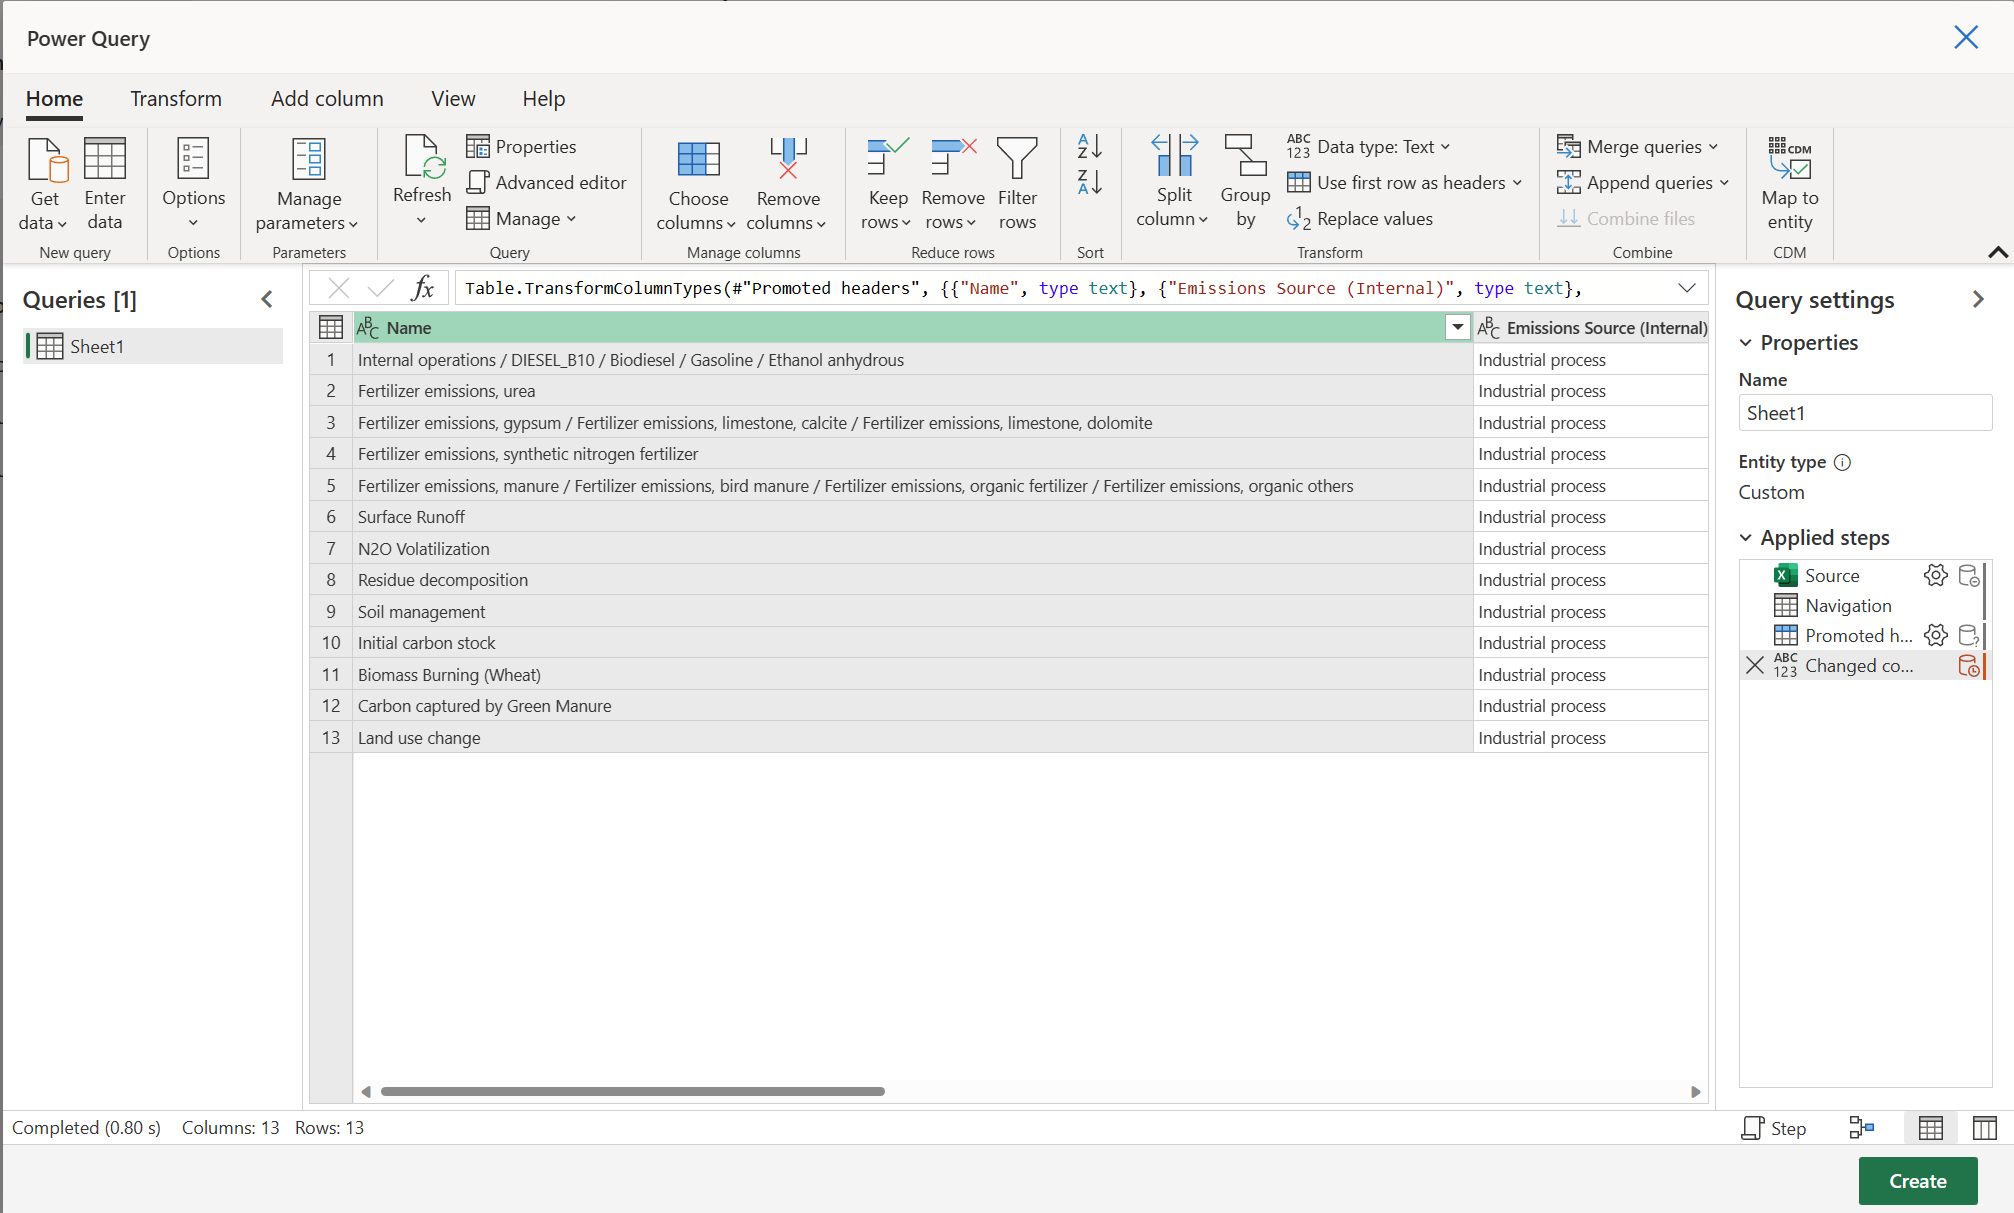

There, you should click the "Map to Entity CDM" button. 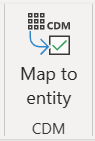

There, click the "Emission" entity, and click the "Auto map" button. 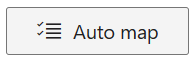

From what we have generated above, we can map the following columns:

The auto mapping button will probably not be able to map the $CO2_{eq}$ column. If that's the case, please map it manually by selecting the "CO2e (mt)" button and selecting the "CO2E (mt)" column from our Excel spreadsheet.

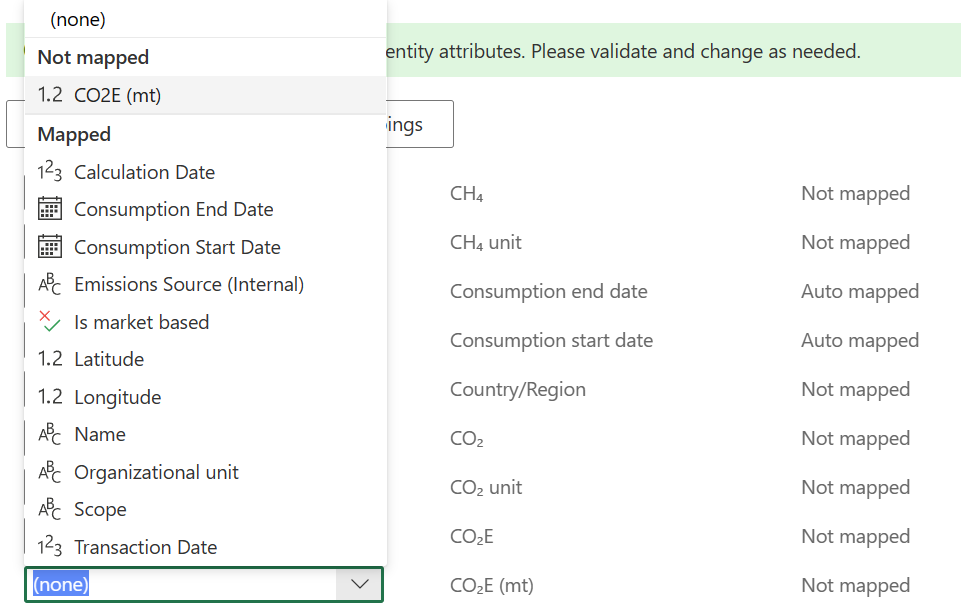

Once that's done, click "Create" to create the data connection and connect it in Sustainability Manager.

When data importing completes, you should be able to view it in the "All emissions" form, as in the example below:

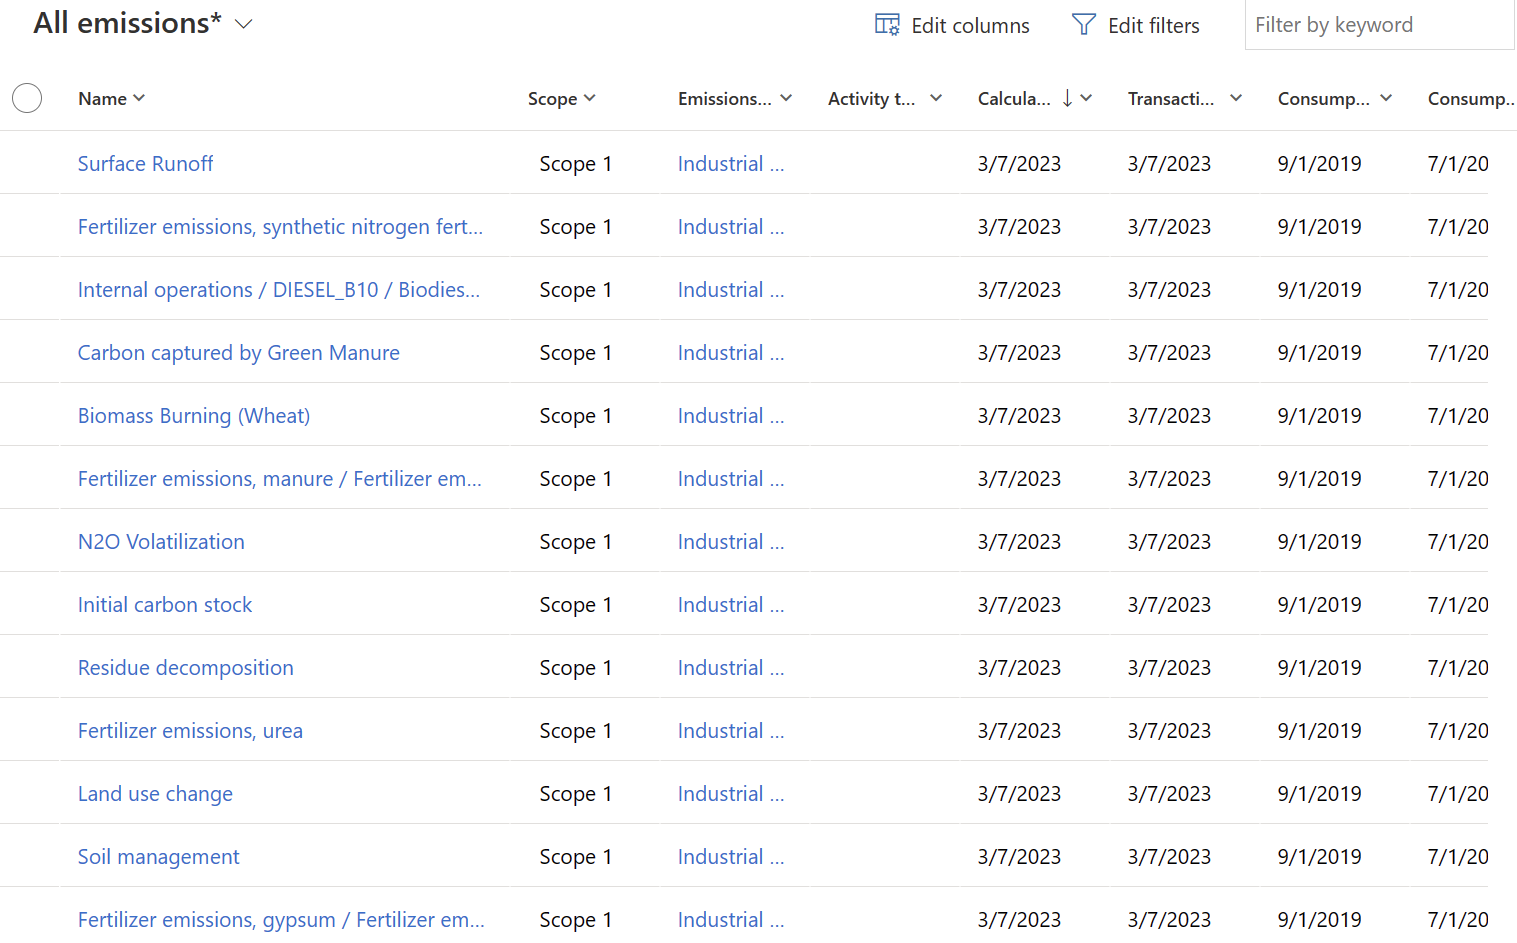

That's it.

Happy carbon reporting! ❤️